## О данных

Будем работать с [датасетом физической активности](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones). 

В этом датасете собраны данные 30 человек, выполняющих различные действия со смартфоном на поясе. Данные записывались с помощью датчиков (акселерометра и гироскопа) в этом смартфоне. Были зафиксированы: "3-осевое линейное ускорение" (_tAcc-XYZ_) и "3-осевая угловая скорость" (_tGyro-XYZ_).

1. Все сигналы отсортированы по времени, пропущены через фильтр шума.
2. Все наблюдения были разделены на окна по 128 сигналов в каждом, причем окна пересекаются на 50% (грубо говоря, с 1 по 128 сигнал в 1 окно, с 64 до 192 сигнала - во 2 окно и так далее).
3. Линейное ускорение было разделено на две составляющие (с помощью низкочастотного фильтра): ускорение самого тела, а также гравитационная составляющая. Будем называть их ускорением тела и гравитационным ускорением.
4. К получившимся окнам применяли различные функции для получения следующих показателей:
    - max
    - min
    - mad (median)
    - mean
    - std
    - skewness (коэффициент асимметричности распределения признака в окне)
    - etc. (подробнее, на сколько это возможно, указано на [страничке датасета](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones))
5. Величина (magnitude) сигнала также определялась через евклидову норму всех значений из вектора для одного окна.
6. К окнам было применено преобразование Фурье, чтобы получить частоты. Из частот были извелченыте же показатели, плюс новые:
    - bandsEnergy (энергия частотного интервала)
7. Были посчитаны углы между векторами соответствующих окон.
8. Для ускорений были посчитаны производные - рывки, к которым применялись те же функции.

Итог: в датасете каждый признак - это какая-то операция над вектором из 128 чисел, которые соответствуют замерам определенного человека занятого какой-то активностью на протяжении 2.56 секунд.

Как читать названия признаков? Примеры:
- `tBodyAccMag-mean()` - это вектор ускорений тела (без гравитационной составляющей этого ускорения), из которого взяли евклидову норму, а затем усреднили, чтобы получить скаляр
- `fBodyAcc-bandsEnergy()-1,8.2` - это вектор ускорения тела, к которому применили преобразование Фурье, преобразовав его в вектор частот, а затем посчитали на этом векторе энергию данного частотного интервала в определенном диапазоне частот (в данном случае 1 - 8.2)
- `angle(X,gravityMean)` - это угол между осью Х и вектором усредненных значений гравитационного ускорения из соответствующего окна

Вероятно, сначала покажется сложным, но мы разберемся с некоторыми признаками в отдельности и вы сможете понять их смысл, уже исходя из фактических соотношений.

## Предобработка данных

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

In [7]:
train.shape

(7352, 563)

В датасете 563 признака, включая целевую переменную. Столько признаков мне не нужно. Сделал подвыборку признаков для удобства работы с ними.

In [8]:
cols_subset = [
    'tBodyAccMag-mean()',  # усредненная величина ускорения тела
    'tBodyGyroJerk-mad()-X',  # медианная величина рывка тела по оси Х
    'tGravityAcc-min()-X',  # минимум гравитационной составляющей ускорения по оси Х
    'tBodyAcc-max()-X',  # максимальная величина ускорения тела по оси Х
    'fBodyAcc-bandsEnergy()-1,8.2',  # энергия ускорения тела в интервале частоты
    'angle(X,gravityMean)',  # угол между осью Х и усредненной гравитационной составляющей ускорения
    'angle(Y,gravityMean)',  # угол между осью Y и усредненной гравитационной составляющей ускорения
    'angle(Z,gravityMean)',  # угол между осью Z и усредненной гравитационной составляющей ускорения,
    'fBodyAcc-skewness()-X',  # асимметричность частоты ускорения тела по оси Х
    'subject',  # номер испытуемого
    'Activity',  # название вида деятельности (целевая переменная)
]

In [9]:
train = train[cols_subset]
test = test[cols_subset]

In [10]:
print(train.isnull().any().any())
print(test.isnull().any().any())
print(train[train.duplicated()])
print(test[test.duplicated()])

False
False
Empty DataFrame
Columns: [tBodyAccMag-mean(), tBodyGyroJerk-mad()-X, tGravityAcc-min()-X, tBodyAcc-max()-X, fBodyAcc-bandsEnergy()-1,8.2, angle(X,gravityMean), angle(Y,gravityMean), angle(Z,gravityMean), fBodyAcc-skewness()-X, subject, Activity]
Index: []
Empty DataFrame
Columns: [tBodyAccMag-mean(), tBodyGyroJerk-mad()-X, tGravityAcc-min()-X, tBodyAcc-max()-X, fBodyAcc-bandsEnergy()-1,8.2, angle(X,gravityMean), angle(Y,gravityMean), angle(Z,gravityMean), fBodyAcc-skewness()-X, subject, Activity]
Index: []


Пропусков нет и так как таблица пуста, то и дублей тоже нет

In [11]:
train.describe()

tBodyAccMag-mean()  tBodyGyroJerk-mad()-X  tGravityAcc-min()-X  \
count         7352.000000            7352.000000          7352.000000   
mean            -0.543884              -0.727735             0.678505   
std              0.477653               0.315832             0.508656   
min             -1.000000              -0.999889            -1.000000   
25%             -0.983282              -0.991595             0.804270   
50%             -0.883371              -0.950268             0.926693   
75%             -0.106892              -0.474625             0.965095   
max              1.000000               1.000000             1.000000   

       tBodyAcc-max()-X  fBodyAcc-bandsEnergy()-1,8.2  angle(X,gravityMean)  \
count       7352.000000                   7352.000000           7352.000000   
mean          -0.468604                     -0.847963             -0.489547   
std            0.544547                      0.233633              0.511807   
min           -1.000000                     -1.000000             -1.000000   
25%           -0.936219                     -0.999480             -0.812065   
50%           -0.881637                     -0.986582             -0.709417   
75%           -0.017129                     -0.764508             -0.509079   
max            1.000000                      1.000000              1.000000   

       angle(Y,gravityMean)  angle(Z,gravityMean)  fBodyAcc-skewness()-X  \
count           7352.000000           7352.000000            7352.000000   
mean               0.058593             -0.056515              -0.128562   
std                0.297480              0.279122               0.403686   
min               -1.000000             -1.000000              -0.931208   
25%               -0.017885             -0.143414              -0.486841   
50%                0.182071              0.003181              -0.163271   
75%                0.248353              0.107659               0.155112   
max                0.478157              1.000000               1.000000   

           subject  
count  7352.000000  
mean     17.413085  
std       8.975143  
min       1.000000  
25%       8.000000  
50%      19.000000  
75%      26.000000  
max      30.000000

Ну что бросается в глаза - данные уже нормализованы, при том каким то скейлером так как данные от -1 до 1 на том спасибо. Как и говорилось ранее нет пропусков можно понять по (count)

In [12]:
test.describe()

tBodyAccMag-mean()  tBodyGyroJerk-mad()-X  tGravityAcc-min()-X  \
count         2947.000000            2947.000000          2947.000000   
mean            -0.559043              -0.735661             0.696878   
std              0.439539               0.282074             0.502873   
min             -0.998936              -1.000000            -0.756774   
25%             -0.978433              -0.989078             0.836787   
50%             -0.861830              -0.914698             0.934930   
75%             -0.149596              -0.486423             0.970871   
max              0.479547               0.117606             0.996148   

       tBodyAcc-max()-X  fBodyAcc-bandsEnergy()-1,8.2  angle(X,gravityMean)  \
count       2947.000000                   2947.000000           2947.000000   
mean          -0.462063                     -0.880361             -0.513923   
std            0.523916                      0.160496              0.509205   
min           -0.952357                     -0.999989             -0.984195   
25%           -0.934447                     -0.999330             -0.829722   
50%           -0.852659                     -0.979336             -0.729648   
75%           -0.009965                     -0.799113             -0.545939   
max            0.786436                      0.048730              0.833180   

       angle(Y,gravityMean)  angle(Z,gravityMean)  fBodyAcc-skewness()-X  \
count           2947.000000           2947.000000            2947.000000   
mean               0.074886             -0.048720              -0.154042   
std                0.324300              0.241467               0.392203   
min               -0.913704             -0.949228              -1.000000   
25%                0.022140             -0.098485              -0.497070   
50%                0.181563             -0.010671              -0.202050   
75%                0.260252              0.092373               0.140254   
max                1.000000              0.973113               0.960367   

           subject  
count  2947.000000  
mean     12.986427  
std       6.950984  
min       2.000000  
25%       9.000000  
50%      12.000000  
75%      18.000000  
max      24.000000

Наблюдей примерно в 2.5 раза меньше чем на тренировочный данных, при этом объектов 23 против 30, странновато как то что не все объекты поучаствуют в тесте, может там какие то аномалии для них на самом деле, уточним карандашиком. Ну средние значения не сильно отличаются, стандартное отклонение тоже в пределах погрешности, думаю с этим проблем не возникнет. Минимальные и максимальные значения отличаются что указывает на то что нормализация проводилась для всех данных сразу а не по отдельности.

In [13]:
print(train['Activity'].value_counts())
print(min(train['Activity'].value_counts())/max(train['Activity'].value_counts()))

Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64
0.7007818052594172


Train: Округленная разница между ними ровно 30%, по тексту условий будем считать что данные сбалансированы

In [14]:
print(test['Activity'].value_counts())
print(min(test['Activity'].value_counts())/max(test['Activity'].value_counts()))

Activity
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64
0.7821229050279329


Test: Округленная разница между ними 22%, по тексту условий будем считать что данные сбалансированы

In [15]:
new_train = pd.get_dummies(train, drop_first=True)
new_test = pd.get_dummies(test, drop_first=True)
new_train.corr()

tBodyAccMag-mean()  tBodyGyroJerk-mad()-X  \
tBodyAccMag-mean()                      1.000000               0.899080   
tBodyGyroJerk-mad()-X                   0.899080               1.000000   
tGravityAcc-min()-X                     0.369962               0.380118   
tBodyAcc-max()-X                        0.959827               0.879900   
fBodyAcc-bandsEnergy()-1,8.2            0.697832               0.507939   
angle(X,gravityMean)                   -0.370849              -0.382246   
angle(Y,gravityMean)                    0.495561               0.478567   
angle(Z,gravityMean)                    0.426283               0.380967   
fBodyAcc-skewness()-X                   0.379796               0.266002   
subject                                -0.073652              -0.110321   
Activity_SITTING                       -0.396389              -0.379403   
Activity_STANDING                      -0.414460              -0.370699   
Activity_WALKING                        0.358825               0.531695   
Activity_WALKING_DOWNSTAIRS             0.561344               0.445048   
Activity_WALKING_UPSTAIRS               0.405434               0.257524   

                              tGravityAcc-min()-X  tBodyAcc-max()-X  \
tBodyAccMag-mean()                       0.369962          0.959827   
tBodyGyroJerk-mad()-X                    0.380118          0.879900   
tGravityAcc-min()-X                      1.000000          0.380404   
tBodyAcc-max()-X                         0.380404          1.000000   
fBodyAcc-bandsEnergy()-1,8.2             0.239088          0.613383   
angle(X,gravityMean)                    -0.988663         -0.384192   
angle(Y,gravityMean)                     0.797116          0.480229   
angle(Z,gravityMean)                     0.667415          0.405023   
fBodyAcc-skewness()-X                   -0.261676          0.335708   
subject                                 -0.042371         -0.055633   
Activity_SITTING                         0.187055         -0.387297   
Activity_STANDING                        0.262354         -0.399861   
Activity_WALKING                         0.234820          0.298526   
Activity_WALKING_DOWNSTAIRS              0.192409          0.658369   
Activity_WALKING_UPSTAIRS                0.159741          0.347429   

                              fBodyAcc-bandsEnergy()-1,8.2  \
tBodyAccMag-mean()                                0.697832   
tBodyGyroJerk-mad()-X                             0.507939   
tGravityAcc-min()-X                               0.239088   
tBodyAcc-max()-X                                  0.613383   
fBodyAcc-bandsEnergy()-1,8.2                      1.000000   
angle(X,gravityMean)                             -0.213318   
angle(Y,gravityMean)                              0.363170   
angle(Z,gravityMean)                              0.423927   
fBodyAcc-skewness()-X                             0.260316   
subject                                          -0.037000   
Activity_SITTING                                 -0.276766   
Activity_STANDING                                -0.296141   
Activity_WALKING                                  0.189834   
Activity_WALKING_DOWNSTAIRS                       0.217399   
Activity_WALKING_UPSTAIRS                         0.534750   

                              angle(X,gravityMean)  angle(Y,gravityMean)  \
tBodyAccMag-mean()                       -0.370849              0.495561   
tBodyGyroJerk-mad()-X                    -0.382246              0.478567   
tGravityAcc-min()-X                      -0.988663              0.797116   
tBodyAcc-max()-X                         -0.384192              0.480229   
fBodyAcc-bandsEnergy()-1,8.2             -0.213318              0.363170   
angle(X,gravityMean)                      1.000000             -0.783848   
angle(Y,gravityMean)                     -0.783848              1.000000   
angle(Z,gravityMean)                     -0.643655              0.594885   
fBodyAcc-skewne

Начнем с позитивного. object почти никак не корелирует с другими с признаками, то есть в зависимости от номера объекта и его показателей нет, то есть данные не имеют смещенности в какую либо сторону, типо чем больше номер человека тем он быстрее выполняет физические нагрузки лучше\хуже. Высокая корреляция между tBodyAccMag-mean() и tBodyGyroJerk-mad()-X, tBodyAcc-max()-X (0.899080, 0.959827), также с другими признаками они коррелируют почти одинаково, это может указывать на избыточность данных, что скажется в процессе обучения, запишем карандашиком, angle(Y,gravityMean) и angle(Z,gravityMean) проблема такая же, но в другом виде, слишком одинаково коррелируют со всем признаками, тоже запишем карандашиком. Интересная вещь это корреляция между angle(X,gravityMean) и tGravityAcc-min()-X равная -0.9898663.

In [16]:
new_test.corr()

tBodyAccMag-mean()  tBodyGyroJerk-mad()-X  \
tBodyAccMag-mean()                      1.000000               0.934773   
tBodyGyroJerk-mad()-X                   0.934773               1.000000   
tGravityAcc-min()-X                     0.407084               0.393773   
tBodyAcc-max()-X                        0.965114               0.898628   
fBodyAcc-bandsEnergy()-1,8.2            0.767875               0.625414   
angle(X,gravityMean)                   -0.400871              -0.387274   
angle(Y,gravityMean)                    0.439051               0.423288   
angle(Z,gravityMean)                    0.425011               0.368411   
fBodyAcc-skewness()-X                   0.365670               0.278765   
subject                                -0.057359              -0.079811   
Activity_SITTING                       -0.401367              -0.395664   
Activity_STANDING                      -0.414812              -0.379256   
Activity_WALKING                        0.382256               0.522026   
Activity_WALKING_DOWNSTAIRS             0.533885               0.464393   
Activity_WALKING_UPSTAIRS               0.399410               0.255742   

                              tGravityAcc-min()-X  tBodyAcc-max()-X  \
tBodyAccMag-mean()                       0.407084          0.965114   
tBodyGyroJerk-mad()-X                    0.393773          0.898628   
tGravityAcc-min()-X                      1.000000          0.386764   
tBodyAcc-max()-X                         0.386764          1.000000   
fBodyAcc-bandsEnergy()-1,8.2             0.301643          0.707129   
angle(X,gravityMean)                    -0.989043         -0.384454   
angle(Y,gravityMean)                     0.697006          0.410477   
angle(Z,gravityMean)                     0.633881          0.398008   
fBodyAcc-skewness()-X                   -0.237864          0.338543   
subject                                  0.004927         -0.071786   
Activity_SITTING                         0.196159         -0.396788   
Activity_STANDING                        0.244371         -0.408003   
Activity_WALKING                         0.227835          0.281951   
Activity_WALKING_DOWNSTAIRS              0.193024          0.638335   
Activity_WALKING_UPSTAIRS                0.163337          0.364582   

                              fBodyAcc-bandsEnergy()-1,8.2  \
tBodyAccMag-mean()                                0.767875   
tBodyGyroJerk-mad()-X                             0.625414   
tGravityAcc-min()-X                               0.301643   
tBodyAcc-max()-X                                  0.707129   
fBodyAcc-bandsEnergy()-1,8.2                      1.000000   
angle(X,gravityMean)                             -0.279783   
angle(Y,gravityMean)                              0.327473   
angle(Z,gravityMean)                              0.446245   
fBodyAcc-skewness()-X                             0.293881   
subject                                          -0.090817   
Activity_SITTING                                 -0.295023   
Activity_STANDING                                -0.323854   
Activity_WALKING                                  0.213190   
Activity_WALKING_DOWNSTAIRS                       0.270809   
Activity_WALKING_UPSTAIRS                         0.524637   

                              angle(X,gravityMean)  angle(Y,gravityMean)  \
tBodyAccMag-mean()                       -0.400871              0.439051   
tBodyGyroJerk-mad()-X                    -0.387274              0.423288   
tGravityAcc-min()-X                      -0.989043              0.697006   
tBodyAcc-max()-X                         -0.384454              0.410477   
fBodyAcc-bandsEnergy()-1,8.2             -0.279783              0.327473   
angle(X,gravityMean)                      1.000000             -0.668108   
angle(Y,gravityMean)                     -0.668108              1.000000   
angle(Z,gravityMean)                     -0.615114              0.425454   
fBodyAcc-skewne

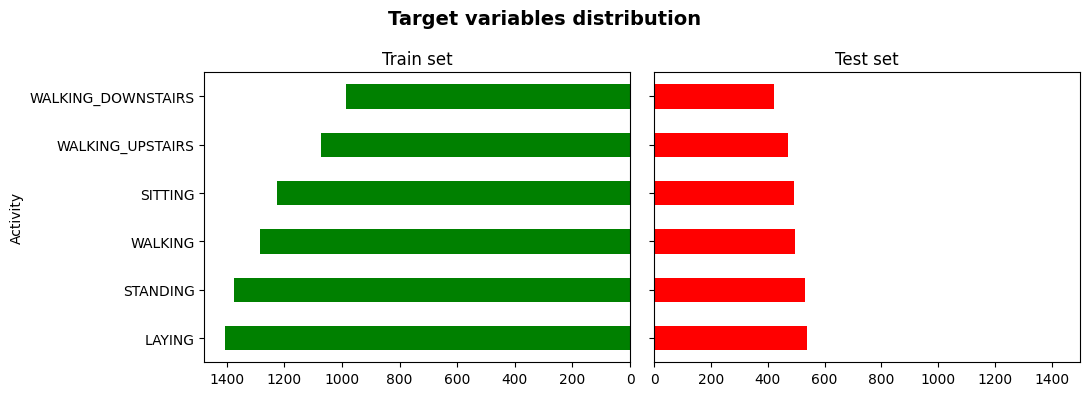

In [18]:
activities = train['Activity']

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

train_df = train['Activity'].value_counts().plot(kind='barh', x='Activity', ax=axes[0], color='green')
axes[0].set_title('Train set')
axes[0].invert_xaxis()
axes[1].set_xlim([0, 1500])
test_df = test['Activity'].value_counts().plot(kind='barh', x='Activity', ax=axes[1], color='red')
axes[1].set_title('Test set')
fig.suptitle('Target variables distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

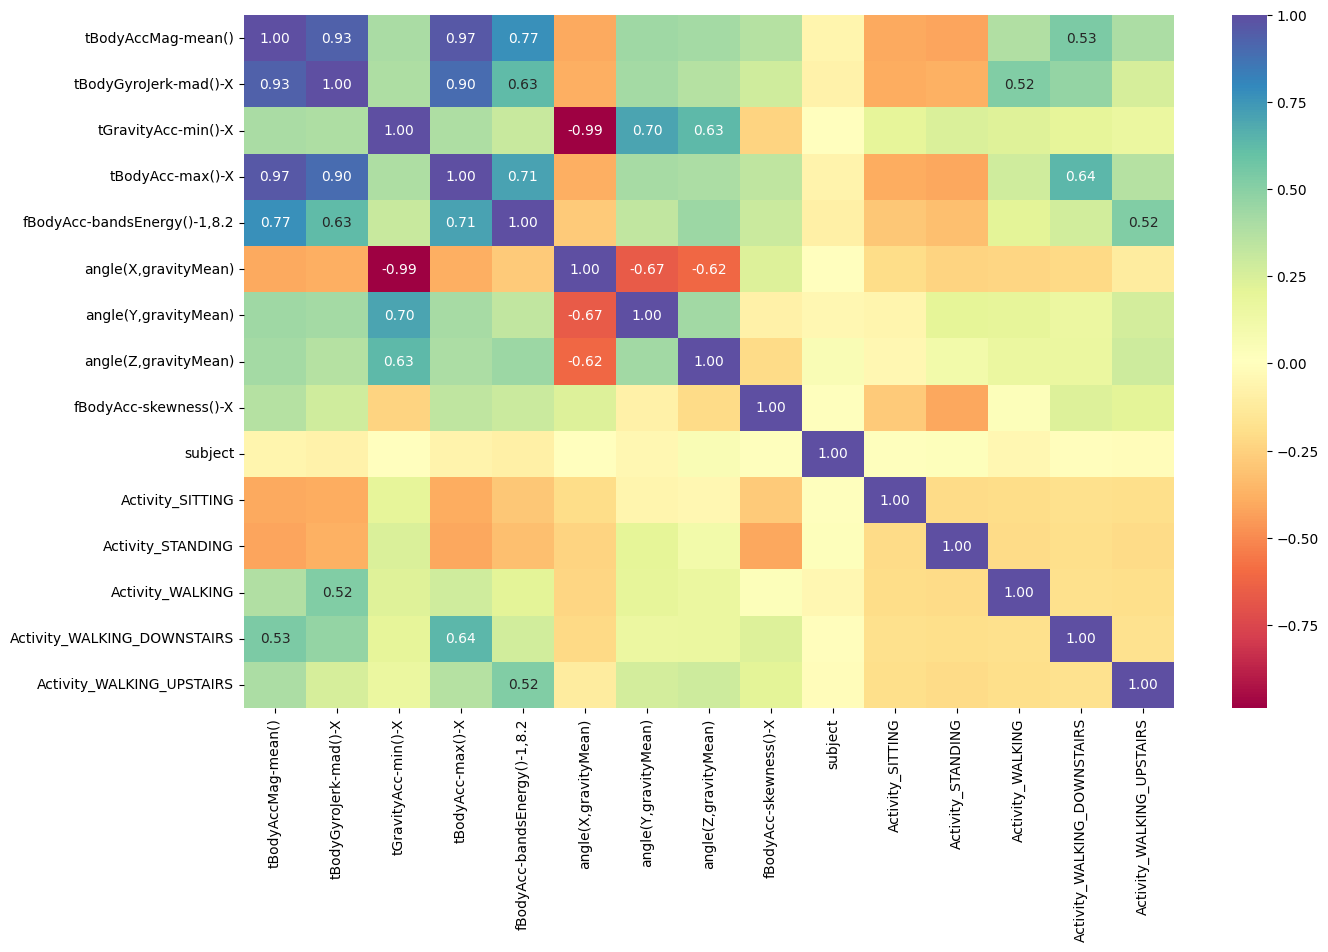

In [19]:
plt.figure(figsize=(15, 9))
ax = sns.heatmap(new_test.corr(), cmap="Spectral", annot=True, fmt="0.2f")
for t in ax.texts:
    if float(t.get_text()) >= 0.5 or float(t.get_text()) <= -0.5:
        t.set_text(t.get_text())
    else:
        t.set_text("")

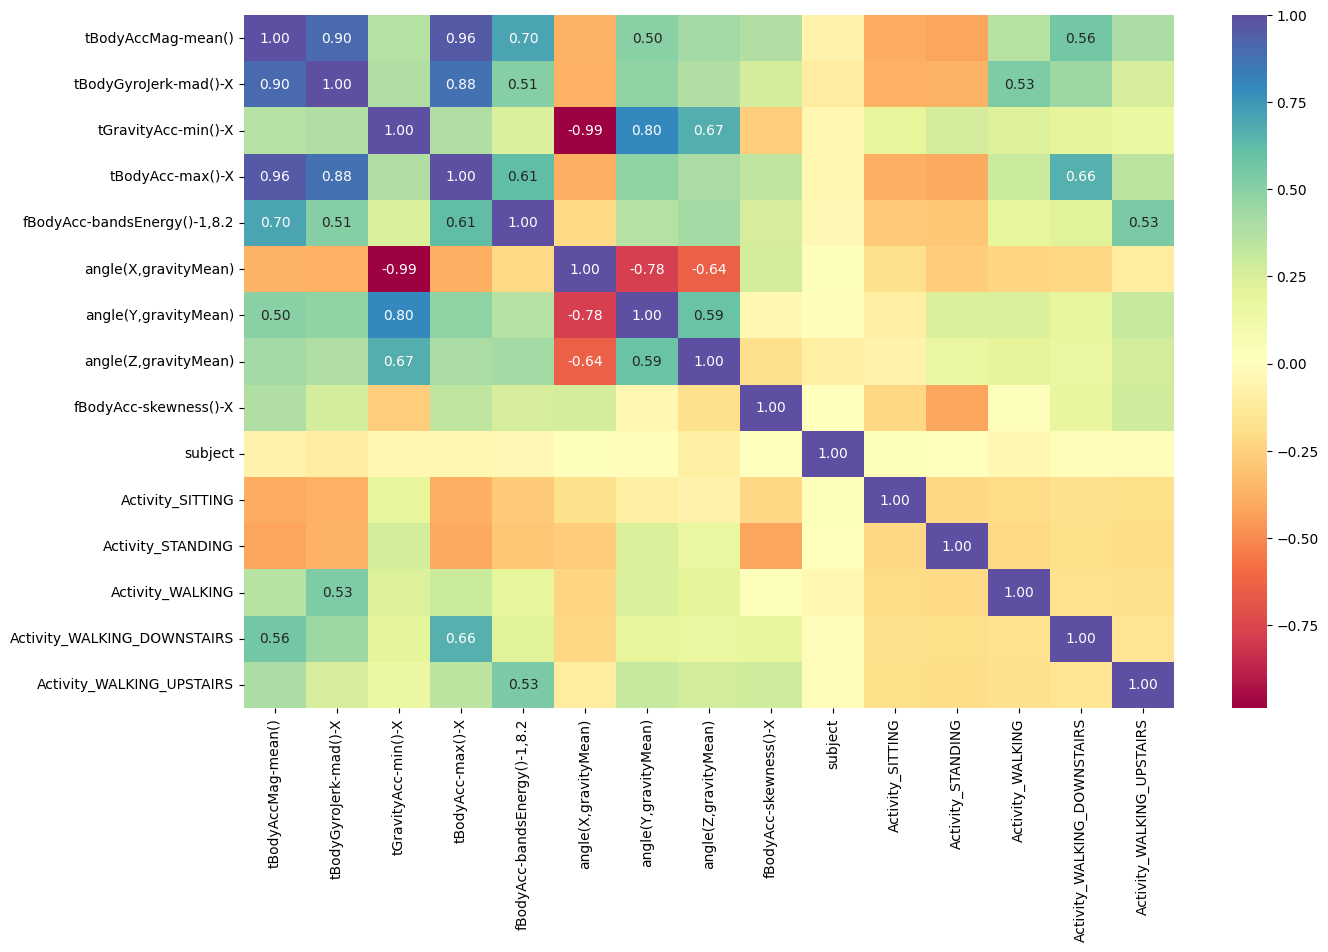

In [20]:
plt.figure(figsize=(15, 9))
ax = sns.heatmap(new_train.corr(), cmap="Spectral", annot=True, fmt="0.2f")
for t in ax.texts:
    if float(t.get_text()) >= 0.5 or float(t.get_text()) <= -0.5:
        t.set_text(t.get_text())
    else:
        t.set_text("")

Ну первым кандидатом на удаление является subject, как я и говорил ранее без всяких тепловых карт, что он никак не коррелирует с другими данными и выявить какую то зависимость от него практически невозможно, что является определенно плюсом, мы знаем что данные собраны независимо, но дальнейшее его рассмотрение не имеет смысла

<Figure size 5000x5000 with 0 Axes>

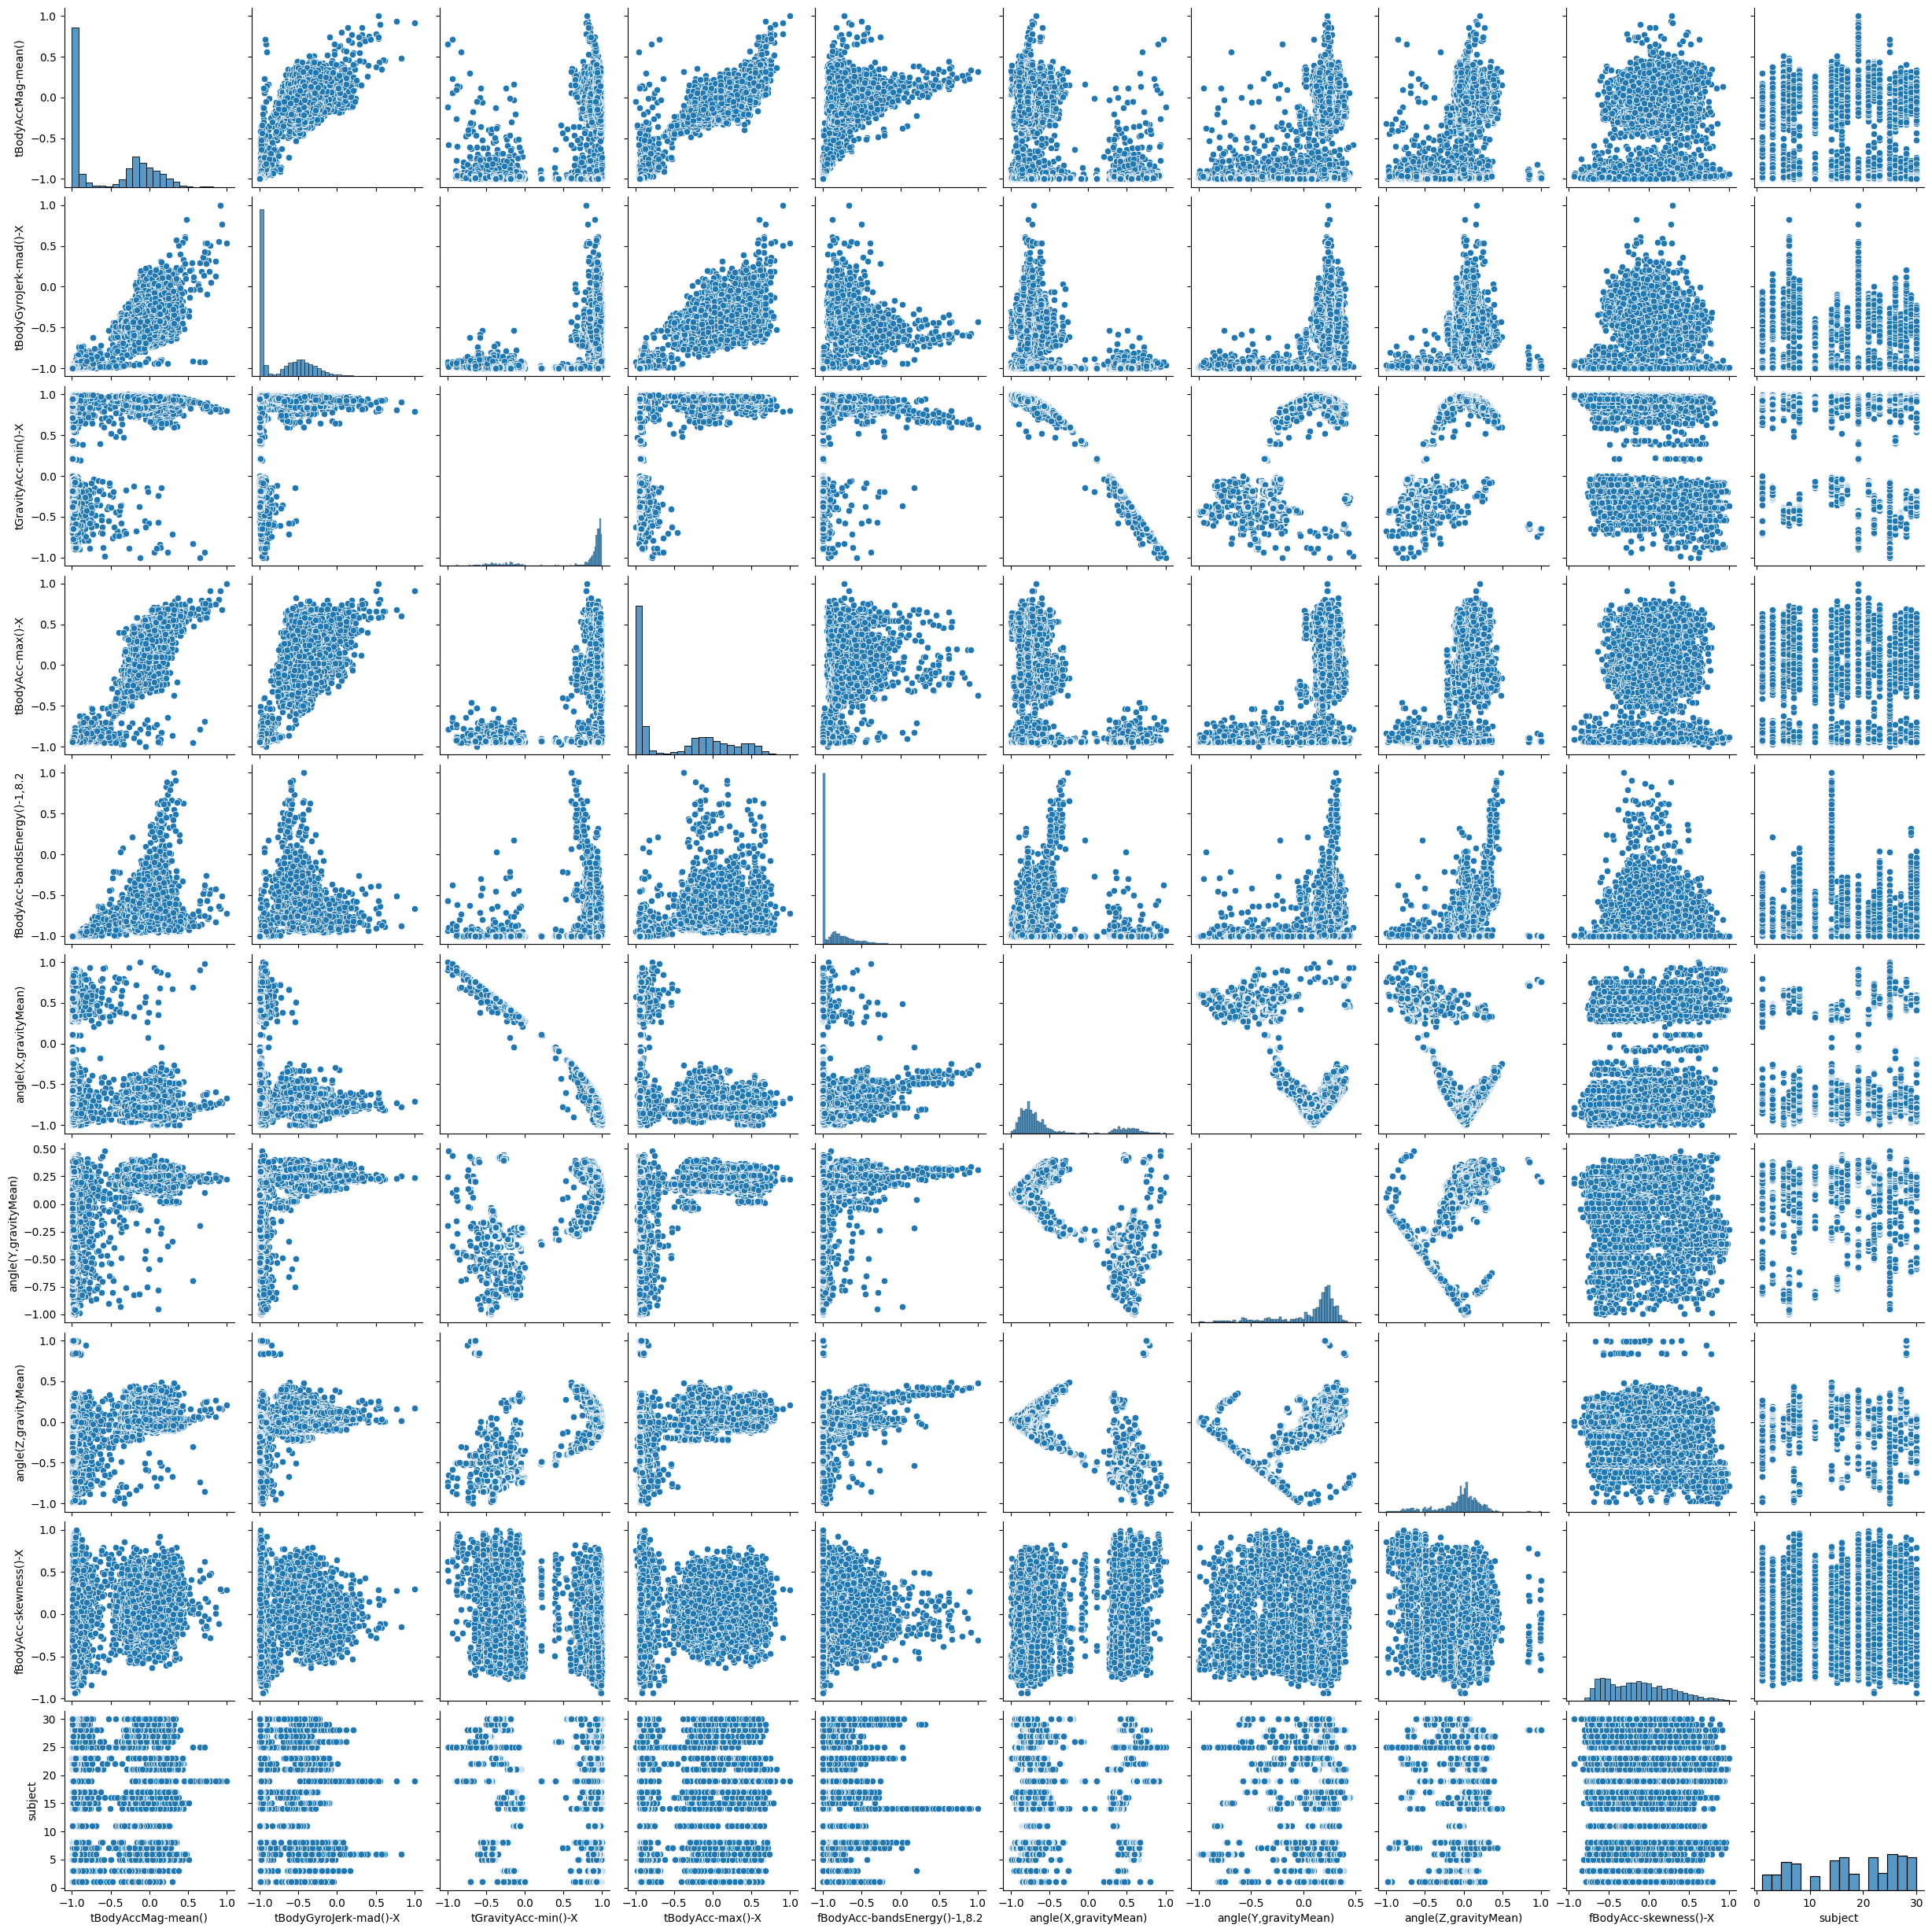

In [21]:
sns.set_style({'axes.grid' : False})
plt.figure(figsize=(50,50))
sns.pairplot(train)
plt.show()

На графиках присутствуют большое количество нелинейный зависимостей, почти на каждом графике есть выбросы данных, понять про выбросы из других графиков мы не могли. Очевидно анализировать не очень удобно картину в целом, но если смотреть на определенные графики то что то новое узнать можно

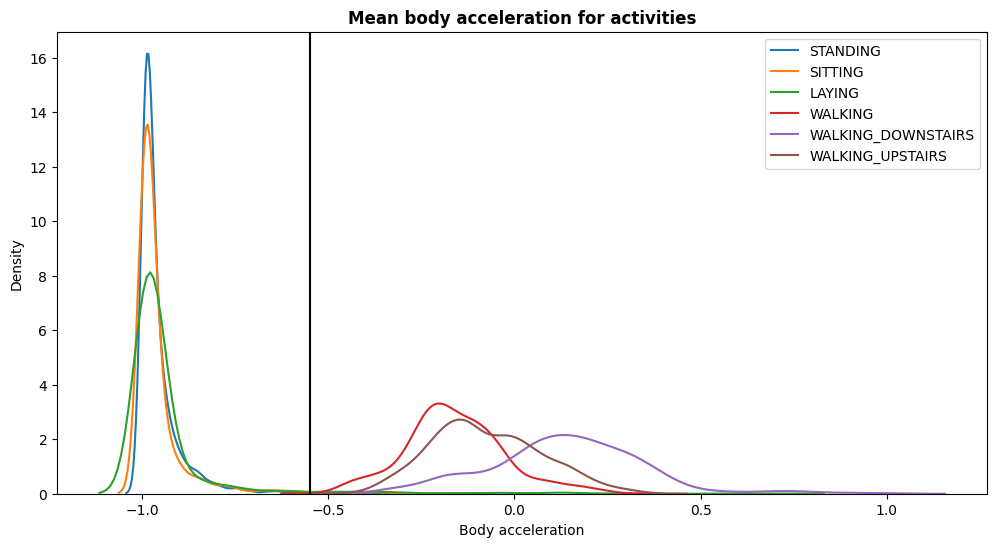

Доля верных ответов = 0.9908868335146899


In [22]:
plt.figure(figsize=(12,6))
sns.set_style({'axes.grid' : False})
for activity in train['Activity'].unique():
    sns.kdeplot(train[train['Activity'] == activity]['tBodyAccMag-mean()'], label=activity)
plt.title('Mean body acceleration for activities', fontweight='bold')
plt.xlabel('Body acceleration')
plt.legend()
plt.axvline(x = -0.55, color = 'black')
plt.show()
count_correct = 0
count_answer = len(train['Activity'])
for i in range(count_answer):
    if (train['tBodyAccMag-mean()'][i] < -0.55 and train['Activity'][i] in ['STANDING','SITTING','LAYING']) or (train['tBodyAccMag-mean()'][i] >= -0.55 and train['Activity'][i] not in ['STANDING','SITTING','LAYING']):
        count_correct +=1
print(f'Доля верных ответов = {count_correct/count_answer}')

По факту это следует из определения tBodyAccMag-mean() - усредненная величина ускорения тела. Все испытуемые примерно одинаково лежат, стоят и сидят, график плотности распределения будет иметь маленькие хвосты, но они по разному выполняют динамические активности и график плотности с более весомыми хвостами. При этом сами активности сильно отличаются по группам, в одном малоподвижные действия, в другом более подвижные, хз че тут распинаться, сравниваем жопу с говном.

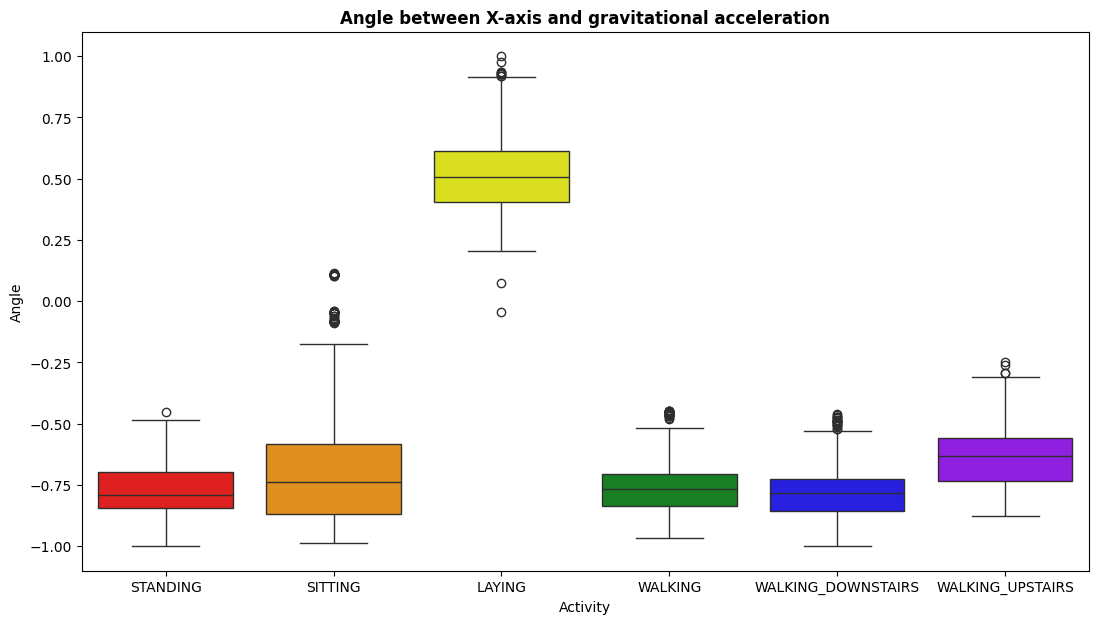

In [23]:
plt.figure(figsize=(13, 7))
my_colors = ['#ff0000', '#ff9500', '#f7ff00', '#098f18', '#0900ff', '#9500ff']
sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=train, palette=my_colors)
plt.xlabel('Activity')
plt.ylabel('Angle')
plt.title('Angle between X-axis and gravitational acceleration', fontweight='bold')
plt.show()

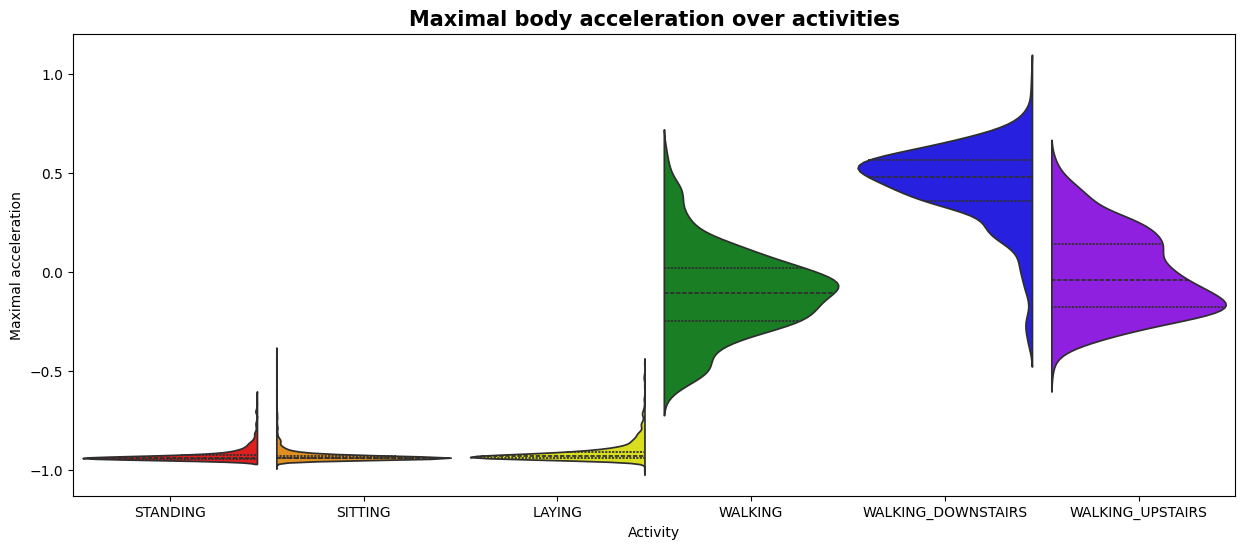

In [24]:
my_colors = ['#ff0000', '#ff9500', '#f7ff00', '#098f18', '#0900ff', '#9500ff']
plt.figure(figsize=(15, 6))
sns.set_style({'axes.grid' : False})
sns.violinplot(x='Activity', y='tBodyAcc-max()-X', data=train, palette=my_colors, width=0.9, inner="quart", split=True)
plt.title('Maximal body acceleration over activities', fontsize=15, fontweight='bold')
plt.xlabel('Activity')
plt.ylabel('Maximal acceleration')
plt.show()

Выделяется Walking_downstairs, по параметру максимального горизонтальному ускорению, так как на спуск человек ускоряется вниз и часть вектора ускорения свободного падения переносится на ось x пропорционально синусу угла наклона, то есть человек в принципе движется быстрее на спуск, как удивительно

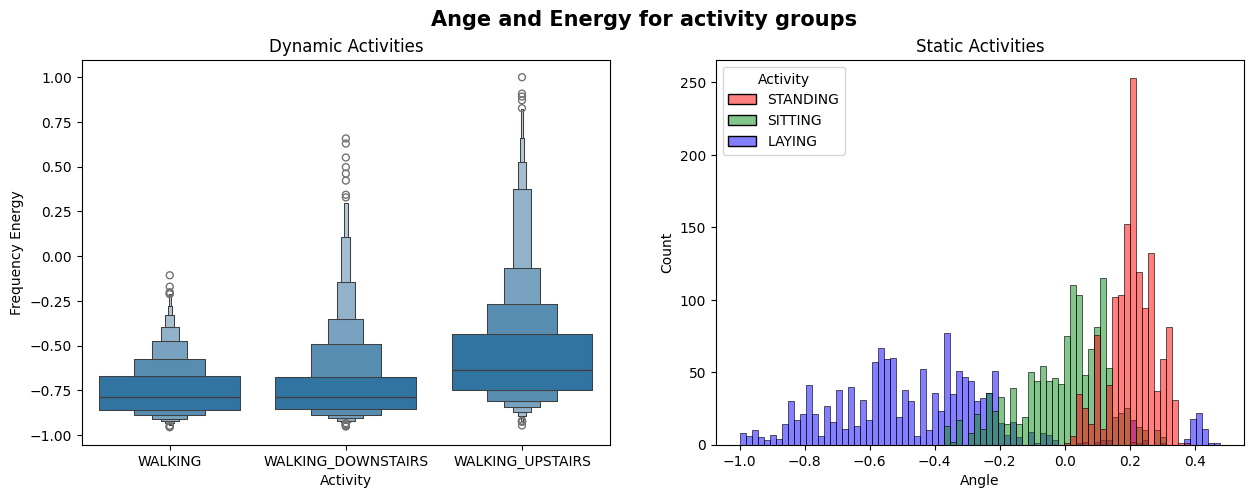

In [25]:
static_train = train[train['Activity'].isin(['SITTING', 'STANDING', 'LAYING'])]
dynamic_train = train[train['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])]

my_new_colors = ['#098f18', '#ff0000', '#0900ff']
palette = dict(zip(['SITTING', 'STANDING', 'LAYING'], my_new_colors))
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxenplot(x='Activity', y='fBodyAcc-bandsEnergy()-1,8.2', data=dynamic_train, ax=axes[0])
axes[0].set_title('Dynamic Activities')
axes[0].set_ylabel('Frequency Energy')

hist_plot = sns.histplot(x='angle(Y,gravityMean)', data=static_train, palette=palette, hue='Activity', bins=80)
plt.title('Static Activities')
plt.xlabel('Angle')

fig.suptitle('Ange and Energy for activity groups', fontsize=15, fontweight='bold')
plt.show()

На подвижных активностях выделяется подъем вверх засчет диапозона значений, на статических активностях выделяется laying и standing, так как человек может занимать разные углы наклона когда лежит, бывает проснулся а ноги на подушке, вот такая жизнь, про стояние могу сказать что его диапозон значений ограничен, человек в среднем немного заваливается вперед

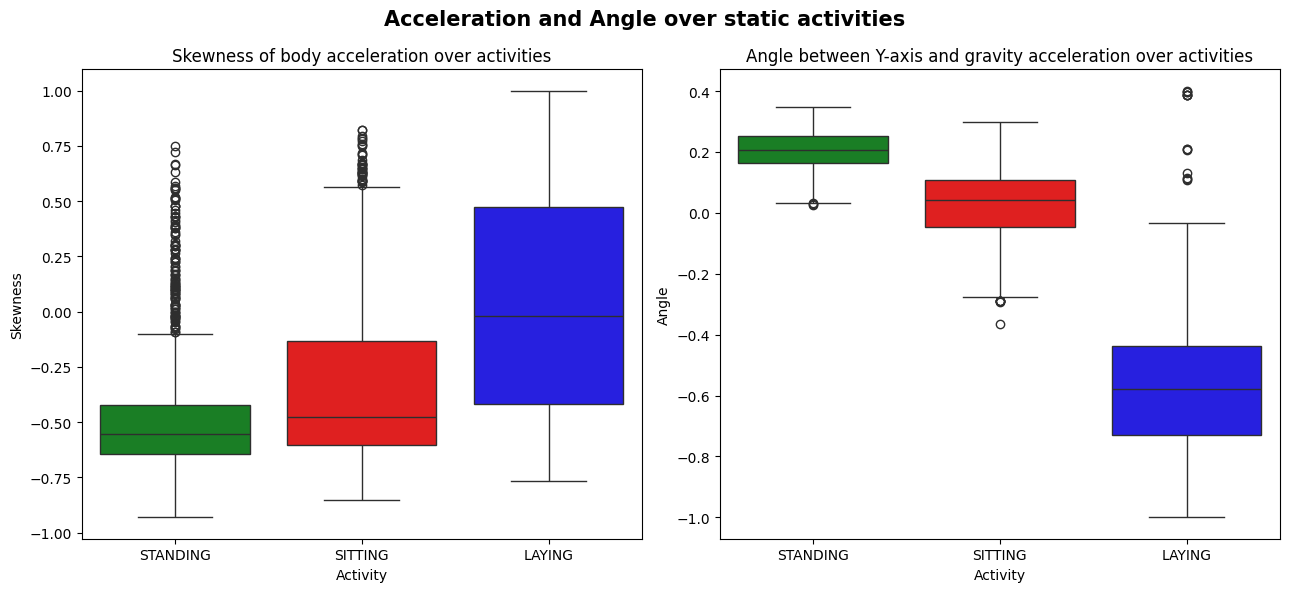

In [26]:
plt.figure(figsize=(13, 6))
plt.suptitle('Acceleration and Angle over static activities', fontsize=15, fontweight='bold')

plt.subplot(1, 2, 1)
sns.boxplot(x='Activity', y='fBodyAcc-skewness()-X', data=static_train,  palette=my_new_colors)
plt.title('Skewness of body acceleration over activities')
plt.xlabel('Activity')
plt.ylabel('Skewness')

filtered_static_train = static_train[static_train['fBodyAcc-skewness()-X'] < -0.376]

plt.subplot(1, 2, 2)
sns.boxplot(x='Activity', y='angle(Y,gravityMean)', data=filtered_static_train,  palette=my_new_colors)
plt.title('Angle between Y-axis and gravity acceleration over activities')
plt.xlabel('Activity')
plt.ylabel('Angle')
plt.tight_layout()
plt.show()

В частности, лежачая активность выделяется своей положительной скошенностью и более низким средним углом, что может нам сказать о более заметном отличии в распределении этих параметров по сравнению с другими

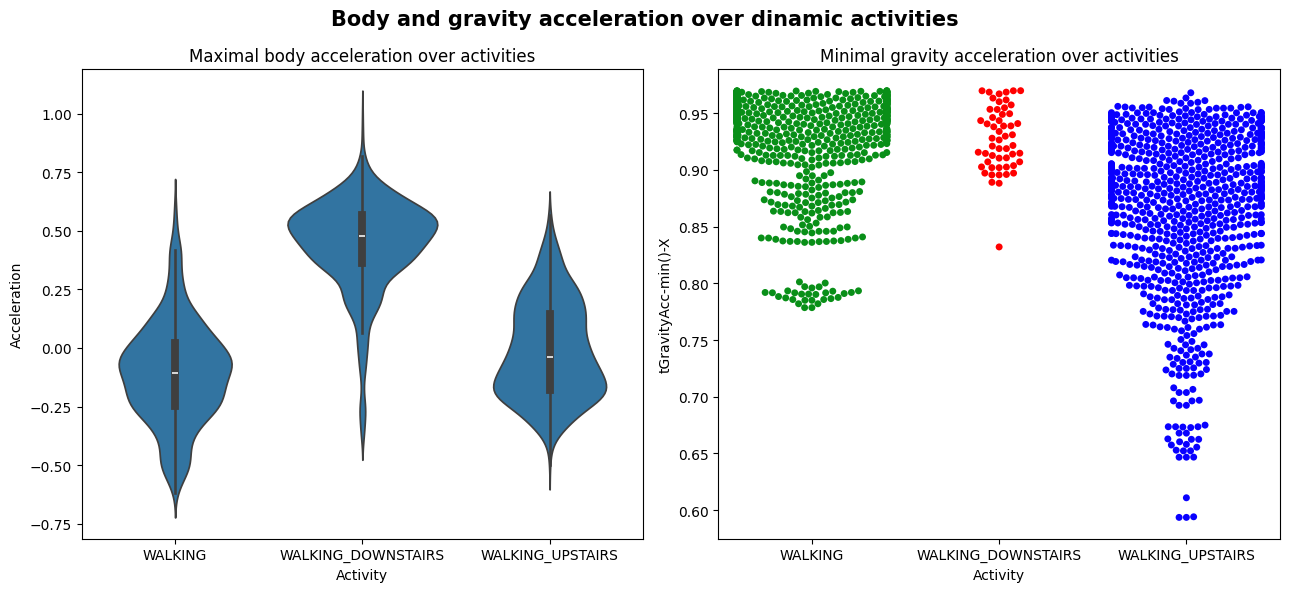

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
fig.suptitle('Body and gravity acceleration over dinamic activities', fontsize=15, fontweight='bold')
sns.violinplot(x='Activity', y='tBodyAcc-max()-X', data=dynamic_train, ax=axes[0])
axes[0].set_title('Maximal body acceleration over activities')
axes[0].set_xlabel('Activity')
axes[0].set_ylabel('Acceleration')
axes[0].tick_params(axis='x')
axes[1].set_xlabel('Activity')
axes[1].set_title('Minimal gravity acceleration over activities')

filtered_train = dynamic_train[dynamic_train['tBodyAcc-max()-X'] < 0.157][dynamic_train[dynamic_train['tBodyAcc-max()-X'] < 0.157]['tGravityAcc-min()-X'] < dynamic_train[dynamic_train['tBodyAcc-max()-X'] < 0.157]['tGravityAcc-min()-X'].quantile(0.83)]

sns.swarmplot(x='Activity', y='tGravityAcc-min()-X', data=filtered_train, palette=my_new_colors, ax=axes[1])

plt.tight_layout()
plt.show()

Walking распределено нормально, имеет скопление точек от 0.9 до 1 на правом графике, слишком малое количество точек у walking_downstairs а walking_upstairs имет большой разброс точек

In [28]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state=666, n_components=2)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_2_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y']),
    train['Activity']
], axis=1)

tsne = TSNE(random_state=666, n_components=3)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_3_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y', 'z']),
    train['Activity']
], axis=1)

CPU times: total: 7min 34s
Wall time: 29.1 s


In [29]:
bimbimbambam = px.scatter(data_frame=df_2_comp, x='x', y='y', color='Activity', hover_name='Activity', width=1000, height=1000)
bimbimbambam.update_xaxes(showgrid=False)
bimbimbambam.update_yaxes(showgrid=False)
bimbimbambam.update_layout(template='simple_white')
bimbimbambam.show()

In [30]:
bimbimbambam = px.scatter_3d(df_3_comp, x='x', y='y', z='z', color='Activity', labels={'x': 'x', 'y': 'y', 'z': 'z'}, hover_name='Activity', width=1000, height=1000)
bimbimbambam.update_xaxes(showgrid=False)
bimbimbambam.update_yaxes(showgrid=False)
bimbimbambam.update_layout(template='simple_white')
bimbimbambam.show()

In [31]:
def predict(df: pd.DataFrame):
    pass


def accuracy_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return (y_true == y_pred).mean()

In [32]:
train_preds = predict(train)
test_preds = predict(test)
print(f"Accuracy on train set => {accuracy_score(train['Activity'], train_preds)}")
print(f"Accuracy on test set => {accuracy_score(test['Activity'], test_preds)}")

Accuracy on train set => 0.0
Accuracy on test set => 0.0
